# Recurrent Inference Machine (RIM) on a toy problem

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import cycle
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn.utils import shuffle
from IPython.display import clear_output

In [6]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the simulator and the data
The simulator is defined as $y=Ax + n$ where $A$ is a deterministic matrix and $n \sim \mathcal{N}(0,\sigma^2)$ with $\sigma$ known. The loss will then be defined to be $\mathcal{L}(x,y)=\frac{1}{2} x^T A^T A x - y^T A x$. To simulate an ill-conditioned problem, we choose $A^T A= \bigl( \begin{smallmatrix}0.1 & 0\\ 0 & 1\end{smallmatrix}\bigr)$, which gives $A=\bigl( \begin{smallmatrix}\sqrt{0.1} & 0\\ 0 & 1\end{smallmatrix}\bigr)$

### Constants

In [114]:
nb_samples = 100
batch_size = 16
time_max_rim = 30
time_max_gd = 60
nb_epochs = 2

size_train = 2000
size_test = 500

# constants for the generation of the dataset
sigma_A = 1
sigma_sigma = 0.5
sigma_x = 1
sigma_x0 = 5

### Simulator

In [115]:
def simulate(x, A, sigma):
    return np.dot(A,x) + np.random.normal(0,sigma**2, (2,))

### Data

In [9]:
A_train = np.array([np.random.normal(0,sigma_A,(2,2)) for i in range(size_train)])
sigma_train = np.array([np.abs(np.random.normal(0,sigma_sigma)) for i in range(size_train)])

X_train = np.array([np.random.normal(0,sigma_x,(2,)) for i in range(size_train)])
Y_train = np.array([simulate(x, A, sigma) for (x, A, sigma) in zip(X_train, A_train, sigma_train)])
X_min_train = np.array([np.linalg.inv(A).dot(y) for (A,y) in zip(A_train,Y_train)])
X0_train = np.array([np.random.normal(x_min,sigma_x,(2,)) for x_min in X_min_train])

In [116]:
A_test = np.array([np.random.normal(0,sigma_A,(2,2)) for i in range(size_test)])
sigma_test = np.array([np.abs(np.random.normal(0,sigma_sigma)) for i in range(size_test)])

X_test = np.array([np.random.normal(0,sigma_x,(2,)) for i in range(size_test)])
Y_test = np.array([simulate(x, A, sigma) for (x, A, sigma) in zip(X_test, A_test, sigma_test)])
X_min_test = np.array([np.linalg.inv(A).dot(y) for (A,y) in zip(A_test,Y_test)])
X0_test = np.array([np.random.normal(x_min,sigma_x0,(2,)) for x_min in X_min_test])

### Loss and gradient

In [154]:
def loss(x, y, A):
    return 0.5 * x.T.dot(A.T).dot(A).dot(x) -  y.T.dot(A).dot(x)

In [155]:
def gradient(x, y, A):
    return A.T.dot(A.dot(x) - y)

### Visualization

In [164]:
extent_x, extent_y = 14, 6
xx_grid = np.array([np.linspace(x_min[0]-extent_x, x_min[0]+extent_x, 50) for x_min in X_min_test])
yy_grid = np.array([np.linspace(x_min[1]-extent_y, x_min[1]+extent_y, 50) for x_min in X_min_test])

In [165]:
XY_grid = np.array([np.meshgrid(xx, yy) for (xx,yy) in zip(xx_grid, yy_grid)])
X_grid = XY_grid[:,0,:,:]
Y_grid = XY_grid[:,1,:,:]
grid = np.concatenate([X_grid[:,:,:,np.newaxis], Y_grid[:,:,:,np.newaxis]], axis=3)

In [166]:
Z_grid = np.array([np.apply_along_axis(lambda x: loss(x, y, A), 2, g) for (y,A,g) in zip(Y_test, A_test, grid)])

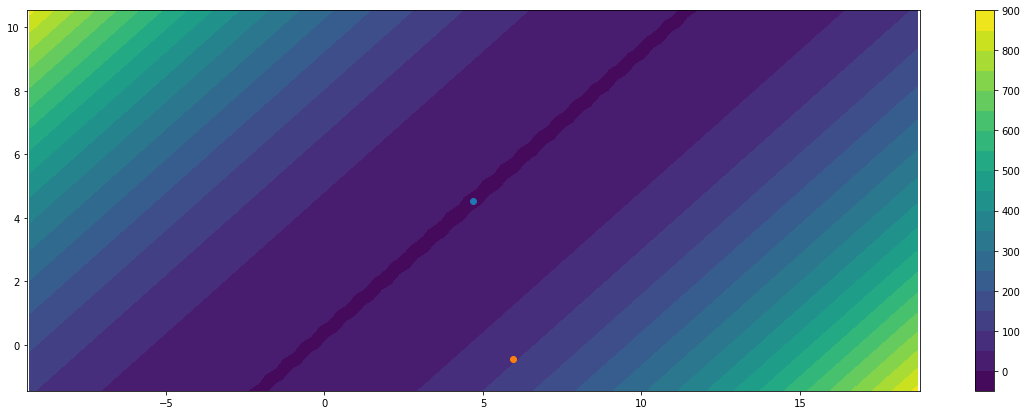

In [169]:
i_example = 18

plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

plt.contourf(X_grid[i_example], Y_grid[i_example], Z_grid[i_example], 20)
plt.colorbar()
plt.scatter(X_min_test[i_example][0], X_min_test[i_example][1])
plt.scatter(X0_test[i_example][0], X0_test[i_example][1])

## Gradient descent

In [170]:
lr = 0.1

In [171]:
list_xt_gd = []
for (x0, y, A) in zip(X0_test, Y_test, A_test):
    xt = x0.copy()
    list_xt = [x0]
    for t in range(1, time_max_gd):
        xt = xt - lr * gradient(xt, y, A)
        list_xt.append(xt)
    list_xt_gd.append(list_xt)
list_xt_gd = np.array(list_xt_gd)

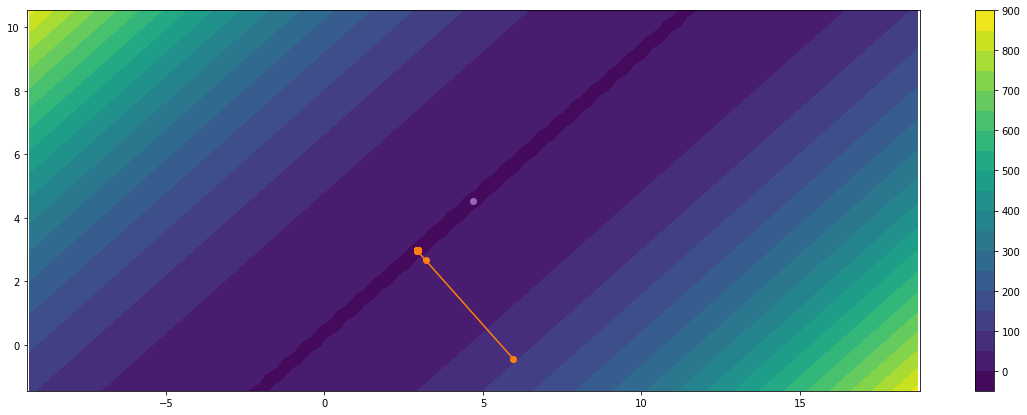

In [172]:
i_example = 18

plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

plt.contourf(X_grid[i_example], Y_grid[i_example], Z_grid[i_example], 20)
plt.colorbar()
plt.scatter(X_min_test[i_example][0], X_min_test[i_example][1], c=colormap[4])
plt.scatter(X0_test[i_example][0], X0_test[i_example][1])

plt.plot(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], color=colormap[1])
plt.scatter(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], c=colormap[1])

## RIM

In [173]:
def weight_loss(t, T):
#     return t/T
    return 1

In [174]:
class RIM(nn.Module):
    def __init__(self, input_size, hidden_size, time_max):
        super(RIM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.time_max = time_max
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        
    def forward(self, xt, st, y, A):
        input = Variable(torch.Tensor(np.concatenate([xt.detach().numpy(), 
                                                      gradient(xt.detach().numpy(), y, A)], 0).reshape(1, 1, 4)))
        out, st = self.rnn(input, st)
        return out.view(self.hidden_size), st
    
    def backprop(self, loss): 
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
    
    def forward_sequence(self, x0, y, x_true, A, phase="test"): 
        xt = Variable(torch.Tensor(x0))
        st = self.init_hidden()
        
        loss = 0
        list_xt = [x0]
        for t in range(self.time_max):
            xt, st = self.forward(xt, st, y, A)
            loss += weight_loss(t,self.time_max) * self.criterion(xt, torch.Tensor(x_true))
            list_xt.append(xt.detach().numpy())
        list_xt = np.array(list_xt)
        
        if phase == "train":
            self.backprop(loss)
        
        return list_xt, loss
        
    def train_batch(self, X_batch, Y_batch, X0_batch, A_batch):
        batch_loss = 0
        for i in range(len(X_batch)):
            x, y, x0, A = X_batch[i], Y_batch[i], X0_batch[i], A_batch[i]
            s0 = self.init_hidden()
            
            list_xt, loss = self.forward_sequence(x0, y, x, A, "test")
            batch_loss += loss
        
        batch_loss /= len(X_batch)
        self.backprop(batch_loss)
        
        return batch_loss
    
    def init_hidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))

### Create the model

In [22]:
rim = RIM(4,2,time_max_rim)

### Training

In [23]:
nb_epochs = 10
for epoch in range(nb_epochs):
    X_train, Y_train, A_train, X0_train, X_min_train, sigma_train = shuffle(X_train, Y_train, A_train, 
                                                                            X0_train, X_min_train, sigma_train)
    loss_epoch = 0
    for i_begin_batch in tqdm(range(0, size_train, batch_size)):
        i_end_batch = (i_begin_batch+batch_size)
        if i_end_batch > size_train:
            next
        X_batch, Y_batch = X_train[i_begin_batch:i_end_batch], Y_train[i_begin_batch:i_end_batch]
        X0_batch, A_batch = X0_train[i_begin_batch:i_end_batch], A_train[i_begin_batch:i_end_batch]

        loss_epoch += rim.train_batch(X_batch, Y_batch, X0_batch, A_batch)
    loss_epoch /= (size_train // batch_size)
    
    clear_output(wait=True)
    print("Epoch {0}, loss: {1:05f}".format(epoch,loss_epoch))

Epoch 9, loss: 13.188335


### Testing

In [175]:
list_xt_rim, losses = [], []
for (x0, y, x, A) in zip(X0_test, Y_test, X_test, A_test):
    list_xt, loss = rim.forward_sequence(x0, y, x, A, "test")
    list_xt_rim.append(list_xt)
    losses.append(loss)
list_xt_rim = np.array(list_xt_rim)
losses = np.array(losses)

### Plotting

Loss: 11.468773


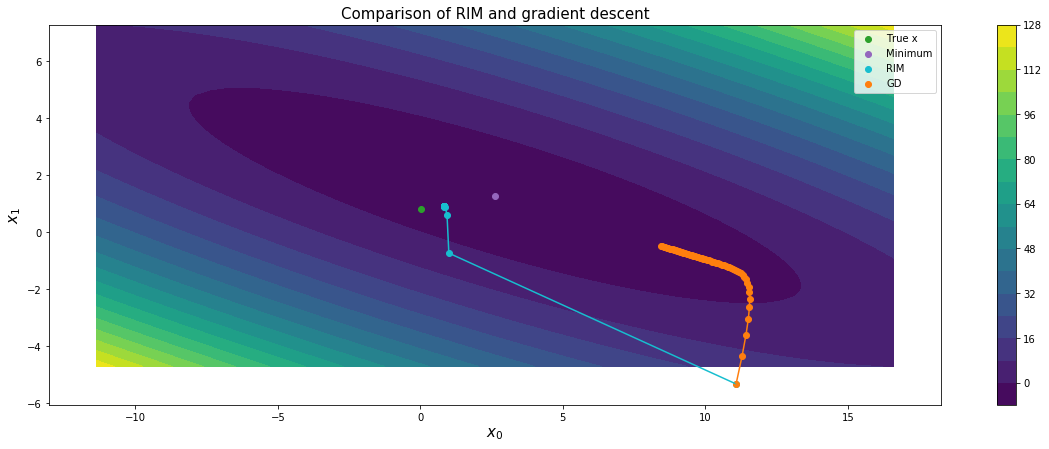

In [178]:
i_example = 19

print("Loss: {0:5f}".format(float(losses[i_example])))

plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

# Plot the loss
plt.contourf(X_grid[i_example], Y_grid[i_example], Z_grid[i_example], 20)
plt.colorbar();
plt.scatter(X_test[i_example][0], X_test[i_example][1], c=colormap[2], zorder=10, label="True x")
plt.scatter(X_min_test[i_example][0], X_min_test[i_example][1], c=colormap[4], zorder=10, label="Minimum")

# Plot the RIM results
plt.plot(list_xt_rim[i_example,:,0], list_xt_rim[i_example,:,1], color=colormap[9])
plt.scatter(list_xt_rim[i_example,:,0], list_xt_rim[i_example,:,1], color=colormap[9], label="RIM")

# Plot the GD results
plt.plot(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], color=colormap[1])
plt.scatter(list_xt_gd[i_example,:,0], list_xt_gd[i_example,:,1], c=colormap[1], label="GD")

plt.xlabel("$x_0$", size=15)
plt.ylabel("$x_1$", size=15)
plt.title("Comparison of RIM and gradient descent", size=15)
plt.legend()
# plt.savefig("screenshots/toy-model-1-sample.png")

### Some statistics

#### Distribution of the distance between the last points and x

##### ... for x=x_true

Average distance to true x with RIM:  0.7857686705178911
Average distance to true x with GD:  2.0787952938165057
STD distance to true x with RIM:  0.578570573706538
STD distance to true x with GD:  5.5153666188337915


(0, 20)

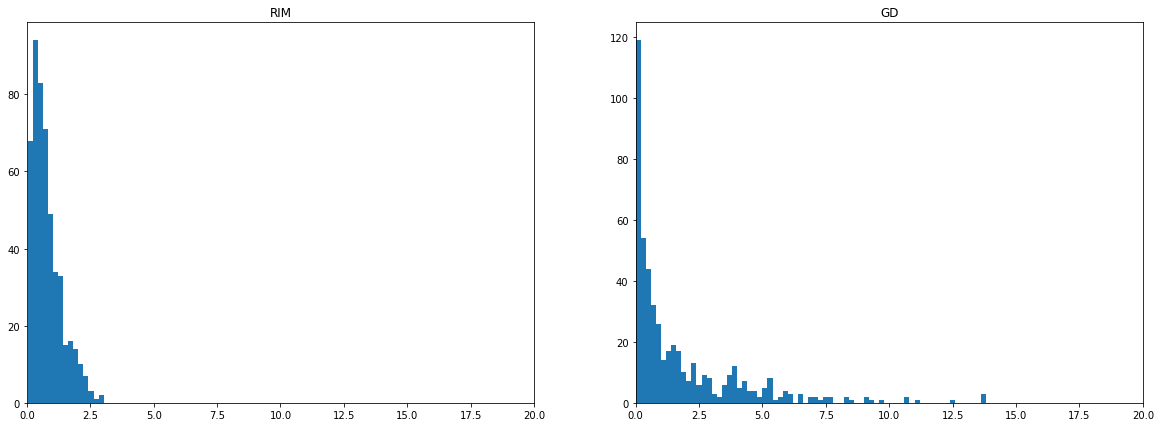

In [183]:
binwidth = 0.2

dist_rim = [np.linalg.norm(list_xt_rim[i][-1] - X_test[i]) for i in range(len(X_test))]
dist_gd = [np.linalg.norm(list_xt_gd[i][-1] - X_test[i]) for i in range(len(X_test))]

mean_rim = np.mean(dist_rim)
mean_gd = np.mean(dist_gd)

std_rim = np.std(dist_rim)
std_gd = np.std(dist_gd)

print("Average distance to true x with RIM: ", mean_rim)
print("Average distance to true x with GD: ", mean_gd)

print("STD distance to true x with RIM: ", std_rim)
print("STD distance to true x with GD: ", std_gd)

plt.subplot(1,2,1)
plt.title("RIM")
hist = plt.hist(dist_rim, bins=np.arange(min(dist_rim), max(dist_rim) + binwidth, binwidth))
plt.xlim(0,20)

plt.subplot(1,2,2)
plt.title("GD")
hist = plt.hist(dist_gd, bins=np.arange(min(dist_gd), max(dist_gd) + binwidth, binwidth))
plt.xlim(0,20)

##### ... for x=x_min

Average distance to min x with RIM:  1.4083664174539343
Average distance to min x with GD:  1.530554038888586
STD distance to min x with RIM:  4.9244932287549865
STD distance to min x with GD:  2.1461494660869236


(0, 20)

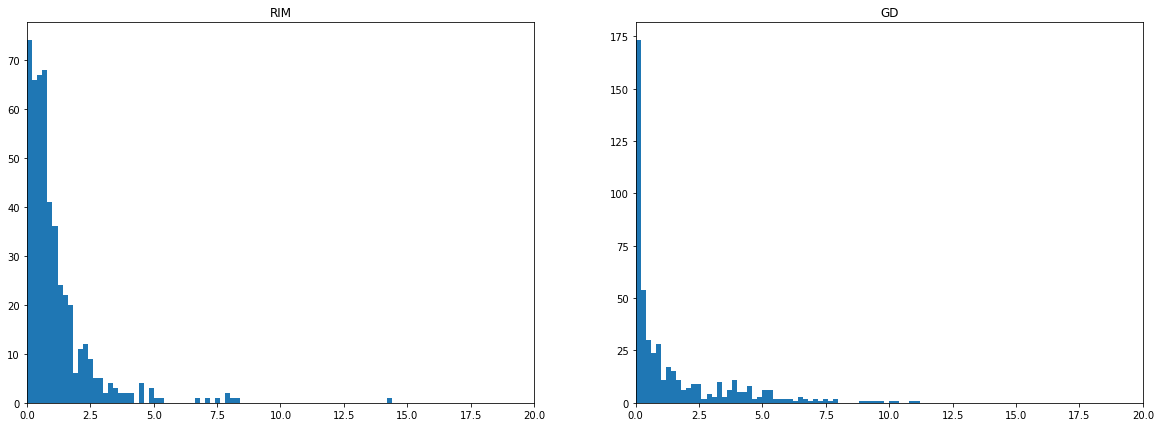

In [184]:
dist_rim = [np.linalg.norm(list_xt_rim[i][-1] - X_min_test[i]) for i in range(len(X_test))]
dist_gd = [np.linalg.norm(list_xt_gd[i][-1] - X_min_test[i]) for i in range(len(X_test))]

mean_rim = np.mean(dist_rim)
mean_gd = np.mean(dist_gd)

std_rim = np.std(dist_rim)
std_gd = np.std(dist_gd)

print("Average distance to min x with RIM: ", mean_rim)
print("Average distance to min x with GD: ", mean_gd)

print("STD distance to min x with RIM: ", std_rim)
print("STD distance to min x with GD: ", std_gd)

plt.subplot(1,2,1)
plt.title("RIM")
hist = plt.hist(dist_rim, bins=np.arange(min(dist_rim), max(dist_rim) + binwidth, binwidth))
plt.xlim(0,20)

plt.subplot(1,2,2)
plt.title("GD")
hist = plt.hist(dist_gd, bins=np.arange(min(dist_gd), max(dist_gd) + binwidth, binwidth))
plt.xlim(0,20)

#### Average distance in function of time

##### ... to x=x_min

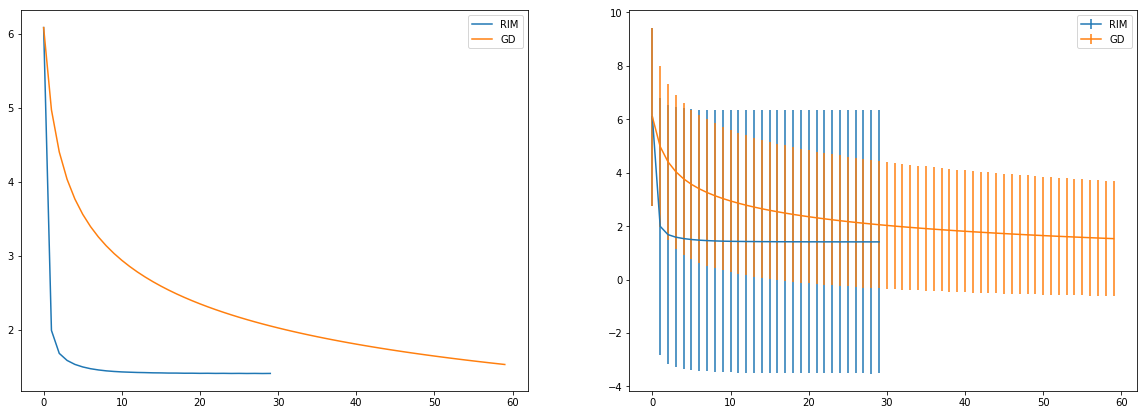

In [200]:
dist_mean_rim = [np.mean([np.linalg.norm(list_xt_rim[i][t] - X_min_test[i]) for i in range(len(X_test))]) for t in range(time_max_rim)]
dist_mean_gd = [np.mean([np.linalg.norm(list_xt_gd[i][t] - X_min_test[i]) for i in range(len(X_test))]) for t in range(time_max_gd)]

dist_std_rim = [np.std([np.linalg.norm(list_xt_rim[i][t] - X_min_test[i]) for i in range(len(X_test))]) for t in range(time_max_rim)]
dist_std_gd = [np.std([np.linalg.norm(list_xt_gd[i][t] - X_min_test[i]) for i in range(len(X_test))]) for t in range(time_max_gd)]

plt.subplot(1,2,1)
plt.plot(dist_mean_rim, label="RIM")
plt.plot(dist_mean_gd, label="GD")
plt.legend()

plt.subplot(1,2,2)
plt.errorbar(np.arange(0,time_max_rim), dist_mean_rim, yerr=dist_std_rim, label="RIM")
plt.errorbar(np.arange(0,time_max_gd), dist_mean_gd, yerr=dist_std_gd, label="GD")
plt.legend()

##### ... to x=x_true

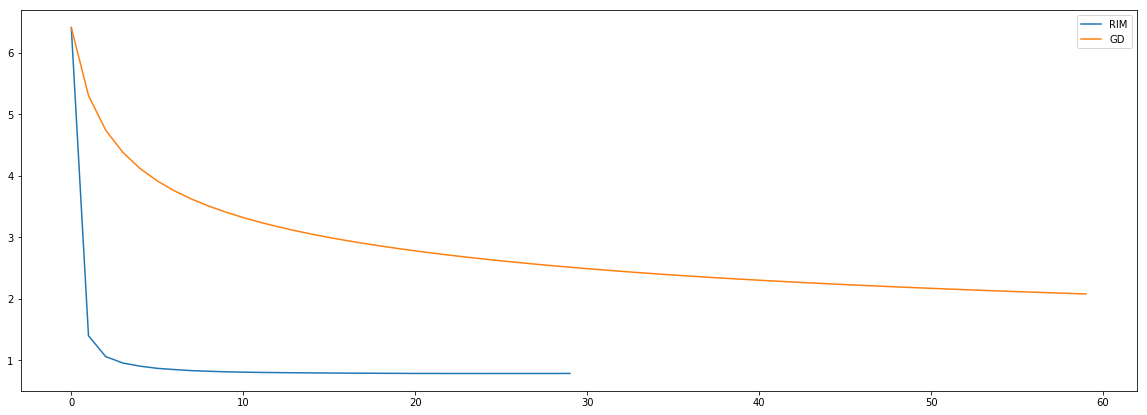

In [187]:
dist_mean_rim = [np.mean([np.linalg.norm(list_xt_rim[i][t] - X_test[i]) for i in range(len(X_test))]) for t in range(time_max_rim)]
dist_mean_gd = [np.mean([np.linalg.norm(list_xt_gd[i][t] - X_test[i]) for i in range(len(X_test))]) for t in range(time_max_gd)]

dist_std_rim = [np.std([np.linalg.norm(list_xt_rim[i][t] - X_test[i]) for i in range(len(X_test))]) for t in range(time_max_rim)]
dist_std_gd = [np.std([np.linalg.norm(list_xt_gd[i][t] - X_test[i]) for i in range(len(X_test))]) for t in range(time_max_gd)]

plt.plot(dist_mean_rim, label="RIM")
plt.plot(dist_mean_gd, label="GD")
plt.legend()